In [1]:
import sys
import os
os.environ["JAX_LOG_COMPILES"] = "0"
import matplotlib.pyplot as plt

import numpy as np

import diffrax
import jax.numpy as jnp
import jax
import scipy
import optax
import jaxopt
from tqdm.auto import tqdm

sys.path.append("../")
import comodi

/data.nst/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## SIR Model

A simple SIR model, where the reduction of the spread is optimized after `delay_restrictions` days such that $N_{\mathrm{infections}} + \overline{\exp \left(1- \mathrm{rel.spreading\,rate} \right)}$ is minimized. $\overline{\cdot}$ denotes the average over time.

In [2]:
N = 10_000
gamma = 1/14

len_sim = 365*2

num_points = 365*2

t_out = np.linspace(0, len_sim, num_points)
t_solve_ODE = np.linspace(0, len_sim, num_points//4)
t_beta = np.linspace(0, len_sim, num_points//4)

R0 = 2
beta_0 = R0*gamma

delay_restrictions = int(min(jnp.argwhere(t_beta > 50)[0]))

cost_weighting = 1

benchmark=True

integrator = comodi.CompModelsIntegrator(
    ts_out=t_out,
    t_0=t_solve_ODE[0],
    t_1=t_solve_ODE[-1],
    ts_solver=t_solve_ODE,
    ts_arg=t_beta,
    interp="cubic",
    solver=diffrax.Bosh3(),  # a 3rd order method
    #adjoint=diffrax.BacksolveAdjoint(),
    adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=len(t_solve_ODE)),
)
SIR_integrator = integrator.get_func(comodi.SIR)


def simulation(x):
    frac_reduc = jax.nn.sigmoid(-x)
    frac_reduc = frac_reduc.at[:delay_restrictions].set(1.)
    beta_t = frac_reduc*beta_0
    
    y0 = {'S': N, 'I': 10, 'R':0}
    const_args = {'gamma': 1/14, 'N': N}
    
    output = jax.jit(SIR_integrator)(
        y0=y0, arg_t=beta_t, constant_args=const_args
    )

    eff_frac_reduc = comodi.interpolation_func(t_beta, frac_reduc, 'cubic').evaluate(t_out)
    return output, eff_frac_reduc

@jax.jit
def min_func(x):
    output, frac_reduc = simulation(x)
    cost = (N - output['S'][-1])/N + jnp.sum(jnp.exp((1-frac_reduc)))/len(frac_reduc) * cost_weighting
    return cost

x_0 = np.zeros(len(t_solve_ODE))
value_and_grad_min_func = jax.jit(jax.value_and_grad(min_func))

if benchmark:
    print("Duration function evaluation: ")
    %timeit min_func(x_0).block_until_ready()
    print("Duration gradient evaluation: ")
    %timeit value_and_grad_min_func(x_0)[0].block_until_ready()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Duration function evaluation: 
121 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Duration gradient evaluation: 
732 µs ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Minimize with scipy.optimize:

In [3]:
%%time
res = scipy.optimize.minimize(min_func, jac=lambda x:value_and_grad_min_func(x)[1], x0 = x_0, method="L-BFGS-B")
print(f"Number of function evaluations: {res.nfev}\n"
      f"Final cost: {res.fun}")

Number of function evaluations: 39
Final cost: 1.6817484453126699
CPU times: user 38.2 ms, sys: 420 µs, total: 38.6 ms
Wall time: 37.6 ms


In [4]:
'''
%%time
# Initialize parameters of the model + optimizer.

#value_and_grad_min_func_jitted = jax.jit(value_and_grad_min_func)

optimizer = jaxopt.LBFGS(value_and_grad_min_func, value_and_grad=True,  jit=False, linesearch="backtracking")#, jit=True)
#optimizer = jaxopt.LBFGS(min_func,  unroll=False, jit=True, linesearch="zoom")#, jit=True)
opt_state = optimizer.init_state(params)
losses = []

for i in (pbar := tqdm(range(200))):
    #
    params, opt_state = optimizer.update(params, opt_state)
    losses.append(opt_state.value)
    pbar.set_description(f"Loss {opt_state.value:.5f}")
    if opt_state.error < 1e-4:
        break
        
    #print(opt_state)
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss");
''';

### Or minimize with jaxopt:

In [5]:
%%time
solver = jaxopt.LBFGS(value_and_grad_min_func, value_and_grad=True, jit=False, linesearch="backtracking") #, jit=False, verbose=True
res = solver.run(x_0)
print(f"Number of iterations: {res.state.iter_num}\n"
      f"Final cost: {res.state.value}")

Number of iterations: 15
Final cost: 1.6823149345441304
CPU times: user 2.05 s, sys: 51.8 ms, total: 2.1 s
Wall time: 2.09 s


### Or the scipy wrapper of jaxopt:

In [6]:
%%time
solver = jaxopt.ScipyMinimize(fun=value_and_grad_min_func, value_and_grad=True, method="L-BFGS-B", jit=False)
res = solver.run(x_0)
print(f"Number of function evaluations: {res.state.iter_num}\n"
      f"Final cost: {res.state.fun_val}")

Number of function evaluations: 36
Final cost: 1.6817484453126699
CPU times: user 67.6 ms, sys: 582 µs, total: 68.2 ms
Wall time: 67.2 ms


(0.0, 200.0)

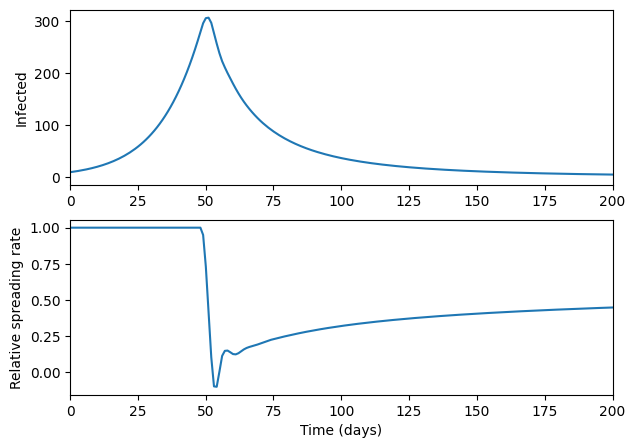

In [7]:
output, frac_reduc = simulation(res.params)
f, axes = plt.subplots(2,1, figsize=(7,5))
f.sca(axes[0])
plt.plot(t_out, output['I'])
plt.ylabel("Infected")
plt.xlim(0,200)
f.sca(axes[1])
plt.plot(t_out, frac_reduc)
plt.ylabel("Relative spreading rate")
plt.xlabel("Time (days)")
plt.xlim(0,200)


## Erlang SEIRS
A little more complicated model with Erlang distributed latent period, infectious period and recovery to susceptible delay. Again the reduction of the spread is optimized after `delay_restrictions` days such that $N_{\mathrm{infections}} + \overline{\exp \left(1- \mathrm{rel.spreading\,rate} \right)}$ is minimized. This is more challenging. The ODEs seems to be stiff, with usual Runga-Kutta methods the solving is somewhat unstable. That's why an implicit solver is chosen here. Second, the optimal solution seems to be an oscillating $\mathrm{rel.spreading\,rate}$. Therefore a parametrization consisting of oscillating terms (sum of cosines) and cubic splines seems indicated. Such a parametrization is however more challenging to fit for the L-BFGS algorithm, that is why an Adam optimizer is used. 

In [8]:
N = 10_000
gamma = 1/14

len_sim = 365 # days

num_points = len_sim

t_out = np.linspace(0, len_sim, num_points)
t_solve_ODE = np.linspace(0, len_sim, num_points)
t_beta = np.linspace(0, len_sim, num_points)
num_osci = 30 # num oscillation terms

R0 = 2
latent_period = 3 # days
infectious_period = 5
recovery_period = 180

ext_infect = 10 # number of external infectious people, constant over time

shape_erlang_kernels = 4

beta_0 = R0/infectious_period

delay_restrictions = int(min(np.argwhere(t_beta > 20))[0])

cost_weighting = 1

benchmark=True


def Erlang_SEIRS(t, y, args):
    reduction_modulation, const_arg = args
    N = const_arg["N"]
    dComp = {}
    #beta = beta_0 * jax.nn.sigmoid(reduction_modulation(t))
    beta = beta_0 * reduction_modulation(t)
    
    I = sum(y["Is"])
    infections = beta * (I+const_arg["ext_infect"]) * y["S"] / N
    dComp["S"] = -infections

    # Latent period
    dEs, outflow = comodi.erlang_kernel(
        inflow=infections,
        Vars=y["Es"],
        rate=const_arg["rate_latent"],
    )
    dComp["Es"] = dEs

    # Infectious period
    dIs, outflow = comodi.erlang_kernel(
        inflow=outflow,
        Vars=y["Is"],
        rate=const_arg["rate_infectious"],
    )
    dComp["Is"] = dIs

    # Recovered/non-susceptible period
    dRs, outflow = comodi.erlang_kernel(
        inflow=outflow,
        Vars=y["Rs"],
        rate=const_arg["rate_recovery"],
    )
    dComp["Rs"] = dRs

    dComp["S"] = dComp["S"] + outflow

    dComp["Tot_infected"] = infections

    return dComp



integrator = comodi.CompModelsIntegrator(
    ts_out=t_out,
    t_0=min(t_out),
    ts_solver=t_solve_ODE,
    interp="cubic",
    ts_arg=t_beta,
    # Use an implicit method for stiff problems, this seems to be a stiff ODE
    solver=diffrax.Kvaerno5(nonlinear_solver=diffrax.NewtonNonlinearSolver(rtol=1e-2, atol=1e-4)),  
    #adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=len(t_solve_ODE)),
    #adjoint=diffrax.BacksolveAdjoint(),
).get_func(Erlang_SEIRS)


len_t_beta = len(t_beta)

def get_simulation_func(with_oscis):
    #assert modulation_form in ("cubic", "cubic-osci", "sigmoid-osci")
    @jax.jit
    def simulation(x):
        x = jnp.array(x)
        y0 = {'S': N, 
              'Es': [10/shape_erlang_kernels for _ in range(shape_erlang_kernels)], 
              'Is': [0 for _ in range(shape_erlang_kernels)],
              'Rs': [0 for _ in range(shape_erlang_kernels)],
              "Tot_infected":0}
        const_args = {'N': N,
                      'rate_latent': 1/latent_period, 
                      'rate_infectious': 1/infectious_period,
                      'rate_recovery': 1/recovery_period,
                      "ext_infect":ext_infect}
        
        
        
        if with_oscis:
            def reduction_modulation_func(t, x):
                reduction_modulation_t  = -x[: len_t_beta].at[:delay_restrictions].set(-1e10)
                red_mod_interp = comodi.interpolation_func(t_beta, reduction_modulation_t, 'cubic')
        
                magnitude_osci = x[len_t_beta: len_t_beta + num_osci]
                period_osci = x[len_t_beta+num_osci: len_t_beta + 2*num_osci]
                period_osci = jnp.maximum(0.5,period_osci)
                offset_osci = x[len_t_beta+2*num_osci: len_t_beta + 3*num_osci]
                red_mod =  red_mod_interp.evaluate(t) + jnp.sum(magnitude_osci[..., None]*jnp.cos(offset_osci[..., None] + t/period_osci[..., None]), axis=0) 
                red_mod = red_mod.squeeze()
                return jax.nn.sigmoid(red_mod)
                #return t*x[0]
        else:
            def reduction_modulation_func(t, x):
                reduction_modulation_t  = -x.at[:delay_restrictions].set(-1e10)
                red_mod_interp = comodi.interpolation_func(t_beta, reduction_modulation_t, 'cubic')
                red_mod = red_mod_interp.evaluate(t)
                return jax.nn.sigmoid(red_mod)
        
        reduction_modulation_func = jax.tree_util.Partial(reduction_modulation_func, x=x)

        output = integrator(
            y0=y0, arg_t=reduction_modulation_func, constant_args=const_args
        )
    
    
        eff_frac_reduc = reduction_modulation_func(t_out)
        
        return output, eff_frac_reduc
    return simulation




Run without oscillation terms in restriction modulation:

Number of function evaluations: 60
Final cost: 1.9144367213897424

Run with oscillation terms in restriction modulation:
Optimize with Adam from optax because LBFGS doesn't work well



  0%|          | 0/2000 [00:00<?, ?it/s]

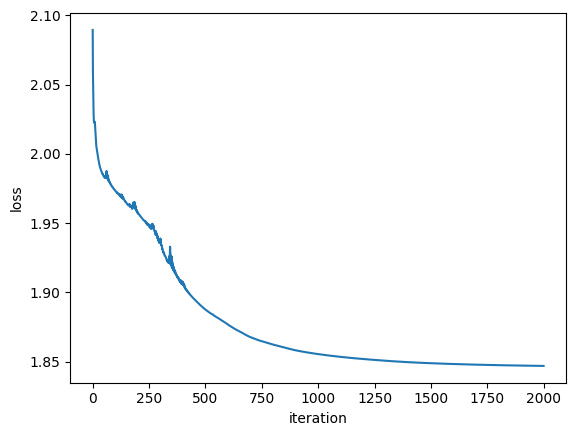

In [9]:
benchmark=False
for with_oscis in [False, True]:
    simulation = get_simulation_func(with_oscis=with_oscis)
    
    if not with_oscis:
        print("\nRun without oscillation terms in restriction modulation:\n")

        @jax.jit
        def min_func(x):
            output, frac_reduc = simulation(x)
            cost = output["Tot_infected"][-1]/N + jnp.sum(jnp.exp(1-frac_reduc))/len(frac_reduc) * cost_weighting
            return cost
        
        
        x_0 = np.zeros(len(t_beta))
        
        grad_min_func = jax.jit(jax.grad(min_func))
        
        if benchmark:
            print("Duration function evaluation: ")
            %timeit min_func(x_0).block_until_ready()
            print("Duration gradient evaluation: ")
            %timeit grad_min_func(x_0).block_until_ready()
        res = scipy.optimize.minimize(min_func, jac=grad_min_func, x0 = x_0, method="L-BFGS-B")
        print(f"Number of function evaluations: {res.nfev}\n"
              f"Final cost: {res.fun}")
    
    else:
        print("\nRun with oscillation terms in restriction modulation:\n"
              "Optimize with Adam from optax because LBFGS doesn't work well\n")

        @jax.jit
        def min_func(x):
            output, frac_reduc = simulation(x)
            cost = output["Tot_infected"][-1]/N + jnp.sum(jnp.exp(1-frac_reduc))/len(frac_reduc) * cost_weighting
            return cost
        
        
        x_0 = np.zeros(len(t_beta) + 3*num_osci)
        x_0[len(t_beta)+1*num_osci: len(t_beta) + 2*num_osci] = np.logspace(np.log10(0.8), np.log10(100), num_osci) 
        x_0[len(t_beta)+2*num_osci: len(t_beta) + 3*num_osci] = np.random.uniform(0, 2*np.pi,size=num_osci) # offset_osci 
        
        value_and_grad_min_func = jax.jit(jax.value_and_grad(min_func))
        
        if benchmark:
            print("Duration function evaluation: ")
            %timeit min_func(x_0).block_until_ready()
            print("Duration gradient evaluation: ")
            %timeit value_and_grad_min_func(x_0)[1].block_until_ready()

        
        start_learning_rate = 5e-2
        schedule = optax.exponential_decay(init_value=start_learning_rate, 
                                           transition_steps=300,
                                           decay_rate=1/2, 
                                           transition_begin=50, 
                                           staircase=False, 
                                           end_value=None)
        optimizer = optax.adam(learning_rate=schedule)

        '''
        params = jnp.array(x_0)
        optimizer = jaxopt.OptaxSolver(value_and_grad_min_func, value_and_grad=True,  jit=True, opt=optimizer)
        #optimizer = jaxopt.LBFGS(value_and_grad_min_func, value_and_grad=True,  jit=False, linesearch="backtracking")#, jit=True)
        #optimizer = jaxopt.LBFGS(min_func,  unroll=False, jit=True, linesearch="zoom")#, jit=True)
        opt_state = optimizer.init_state(params)
        losses = []
        
        for i in (pbar := tqdm(range(1000))):
            #
            params, opt_state = optimizer.update(params, opt_state)
            losses.append(opt_state.value)
            pbar.set_description(f"Loss {opt_state.value:.5f}")
            if opt_state.error < 1e-4:
                break
                
            #print(opt_state)
        '''
        # Initialize parameters of the model + optimizer.
        params = jnp.array(x_0)
        opt_state = optimizer.init(params)
        losses = []
        
        for i in (pbar := tqdm(range(2000))):
            func_val, grads = value_and_grad_min_func(params)
            pbar.set_description(f"Loss {func_val:.5f}")
            losses.append(func_val)
            updates, opt_state = optimizer.update(grads, opt_state)
            #print(opt_state)
            params = optax.apply_updates(params, updates)
        
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")

        

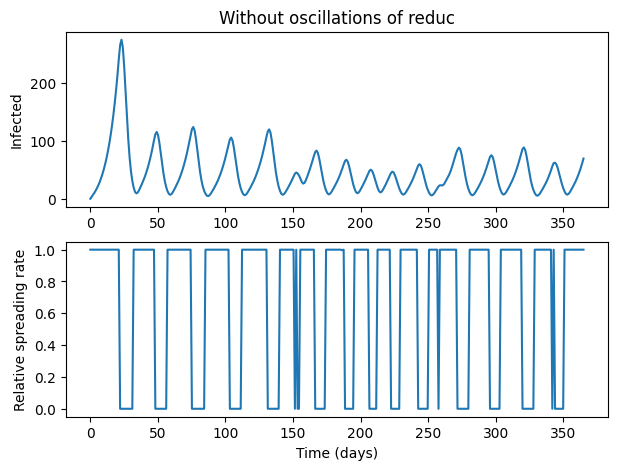

Period of max component: 18.25 days


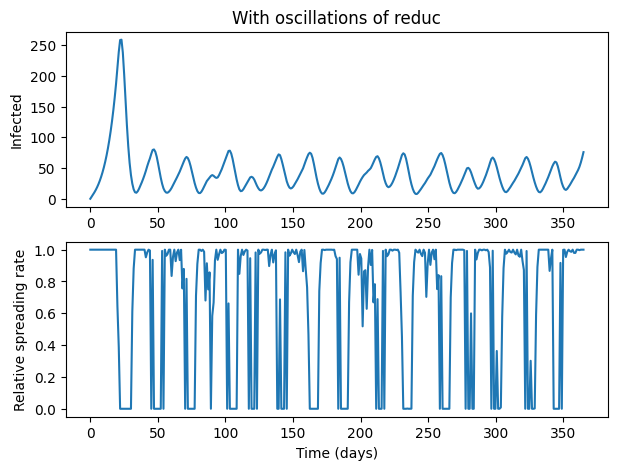

Period of max component: 15.87 days


In [10]:
for x_values, with_oscis in zip([res.x, params],[False, True]):
    simulation = get_simulation_func(with_oscis=with_oscis)
    output, frac_reduc = simulation(x_values)
    f, axes = plt.subplots(2,1, figsize=(7,5))
    f.sca(axes[0])
    plt.title(f"{'With' if with_oscis else 'Without'} oscillations of reduc")
    plt.plot(t_out, sum(output['Is']))
    plt.ylabel("Infected")
    f.sca(axes[1])
    plt.plot(t_out, frac_reduc)
    plt.ylabel("Relative spreading rate")
    plt.xlabel("Time (days)")
    plt.show()

    fft = np.fft.fft(frac_reduc)
    freq = np.fft.fftfreq(frac_reduc.shape[-1])
    fft = fft[1:len(fft)//2]
    freq = freq[1:len(freq)//2]
    #plt.plot(freq, fft.real)
    print(f"Period of max component: {1/freq[np.argmax(fft.real)]:.2f} days")
    